# 1 - Introduction

`Nama :` Rhesa Akbar Elvarettano

`Batch :` SBY-003

`Background:`Kebutuhan daging sapi terus melambung tinggi dari tahun ke tahun sejalan dengan pertambahan jumlah penduduk Indonesia yang semakin tinggi pula. Selain itu, permintaan daging sapi lokal akan melonjak naik terutama pada hari-hari besar seperti saat Ramadhan dan hari raya Idul Fitri. Namun, hal ini berbanding terbalik dengan volume daging sapi lokal yang dapat diproduksi. Hal ini mengakibatkan tingginya harga jual daging sapi di pasar dan mengakibatkan beberapa oknum pedagang melakukan kecurangan untuk memperoleh keuntungan, salah satunya yaitu menjual daging yang tidak layak dikonsumsi seperti daging busuk. Selama ini untuk membedakan daging segar dan daging yang tidak layak dikonsumsi dapat dilihat dari warna, kadar air, bau daging. Namun, cara tersebut belum tentu akurat. Untuk mengatasi hal tersebut, saya membuat model berbasis Convotional Neural Network untuk mengetahui kesegaran daging.

`Objective:` Dalam project ini membuat model menggunakan deep learning untuk mengklasifikasikan gambar daging sesuai kelasnya yaitu kelas fresh, half & spoiled.

`Dataset:` https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset/data

# 2 - Import Libraries

In [ ]:
# Import libraries

import shutil
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.xception import Xception

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [ ]:
# Install Kaggle library in Google Collaboratory

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset

!kaggle datasets download -d vinayakshanawad/meat-freshness-image-dataset

 71% 42.0M/59.4M [00:01<00:00, 18.7MB/s]
100% 59.4M/59.4M [00:01<00:00, 35.4MB/s]
CPU times: user 34.2 ms, sys: 2.64 ms, total: 36.8 ms
Wall time: 3.22 s


In [ ]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip ./meat-freshness-image-dataset.zip

Archive:  ./meat-freshness-image-dataset.zip
  inflating: Meat Freshness.v1-new-dataset.multiclass/README.dataset.txt  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1-_JPG.rf.65663691924ca0aede3884b863267c98.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-100-_JPG.rf.65e835ab6a2890785aade192d1e19549.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1000-_JPG.rf.d0f18a5c4075b50beeb7ee99036d491d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1003-_JPG.rf.b410c33a04a1fba90032a9086d191d6d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1005-_JPG.rf.404839308dfdce0228de77bf7458513a.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1009-_JPG.rf.1c4c304a072d95160d6ec26f0191344e.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-101-_JPG.rf.4c18cd9fd197ac72fa9dd68fcd00502f.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train

In [ ]:
# Define path
main_path = '/content/Meat Freshness.v1-new-dataset.multiclass'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'valid')

In [ ]:
import os
print(os.listdir('/content/Meat Freshness.v1-new-dataset.multiclass'))

['train', 'README.dataset.txt', 'valid']


In [ ]:
# Function to create class folders and move images
def organize_data(source_path, dest_path):
    # Create class folders
    classes = set()
    for filename in os.listdir(source_path):
        if filename.endswith('.jpg'):
            class_name = filename.split('-')[0]  # Extract class label from filename
            classes.add(class_name)
            class_dir = os.path.join(dest_path, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            shutil.move(os.path.join(source_path, filename), os.path.join(class_dir, filename))
    return classes

# Move images in training data
train_classes = organize_data(train_path, train_path)
print('Training classes:', train_classes)

# Move images in test data
test_classes = organize_data(test_path, test_path)
print('Test classes:', test_classes)

# Function to count the number of images in each class folder
def check_path(path):
    classes = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    for class_name in classes:
        num_data = len(os.listdir(os.path.join(path, class_name)))
        print(f'Total Data - {class_name} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Training classes: {'HALF', 'FRESH', 'SPOILED'}
Test classes: {'HALF', 'FRESH', 'SPOILED'}
Train Path
Total Data - HALF : 630
Total Data - FRESH : 675
Total Data - SPOILED : 510

Test Path
Total Data - HALF : 159
Total Data - FRESH : 178
Total Data - SPOILED : 114



# 4 - Exploratory Data Analysis (EDA)

In [ ]:
# Membuat visualisasi sederhana dari 5 gambar berdasarkan kelasnya
def plot_images(path):
    labels = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    for label in labels:
        folder_path = os.path.join(path, label)
        fig = plt.figure(figsize=(20, 20))
        columns = 5
        rows = 1
        print('Class : ', label)
        images = os.listdir(folder_path)[:5]  # Limit to the first 5 images
        for index, image_name in enumerate(images, start=1):
            fig.add_subplot(rows, columns, index)
            image = plt.imread(os.path.join(folder_path, image_name))
            plt.imshow(image)
            plt.axis("off")
        plt.show()

Class :  HALF


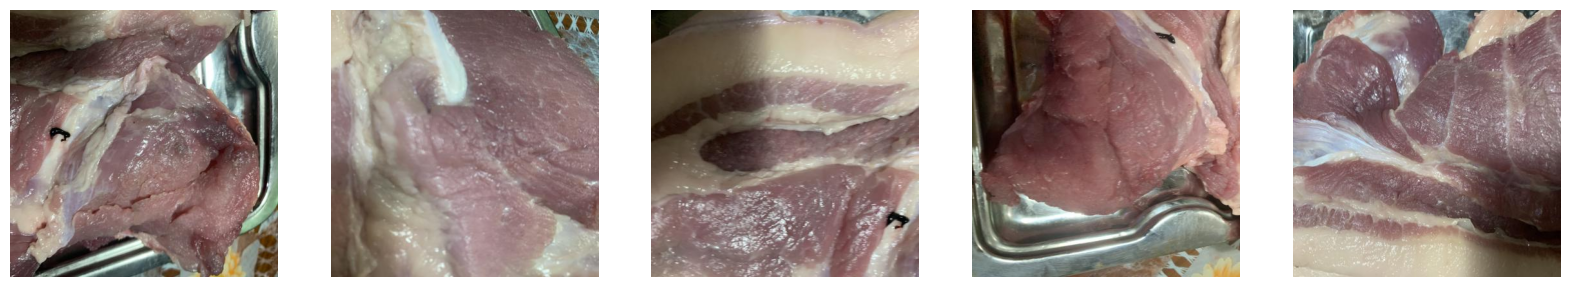

Class :  FRESH


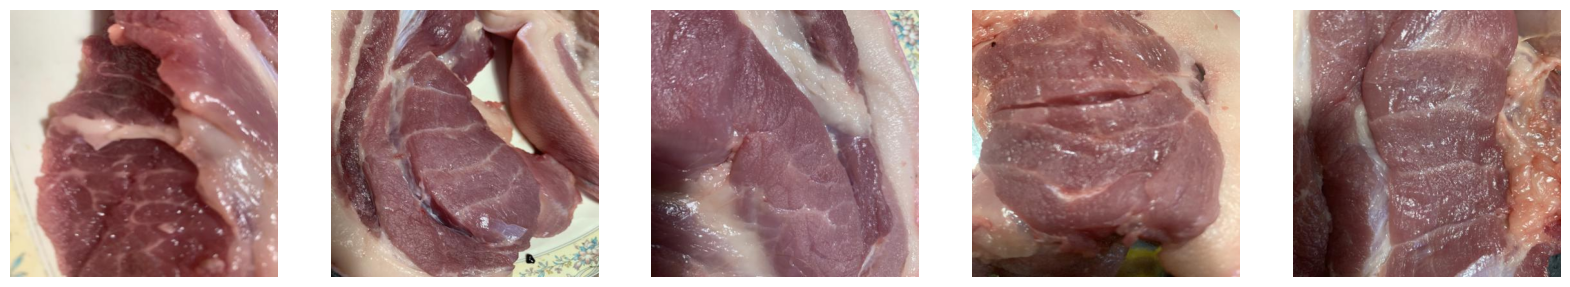

Class :  SPOILED


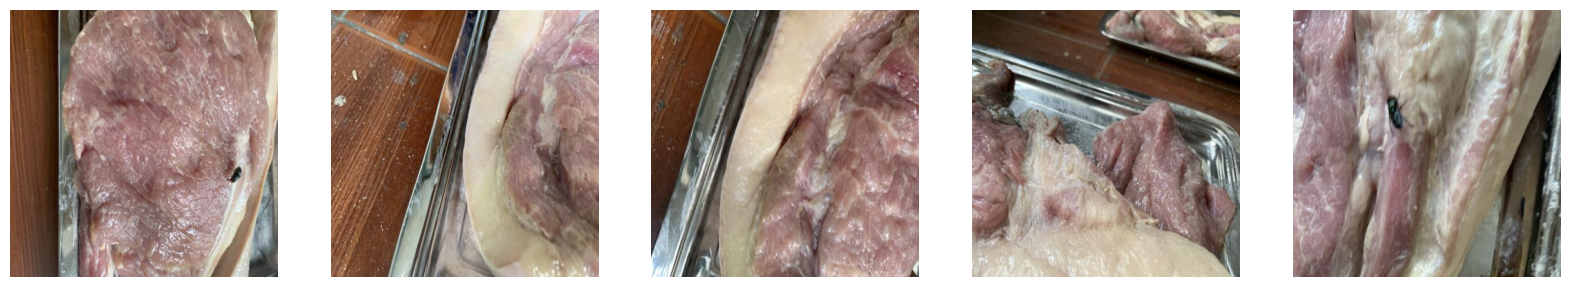

In [ ]:
# Visualization of train_path

plot_images(train_path)

**Ciri-ciri:**

**Daging Busuk (SPOILED):**

- Warna secara keseluruhan sudah sangat gelap atau berubah menjadi warna coklat atau hitam.
- Permukaan daging terlihat sangat kering dan mungkin ada tanda-tanda pertumbuhan jamur atau bakteri.

**Daging Segar (FRESH):**

- Warna cerah dan merata.
- Permukaan daging tampak lebih berwarna merah cerah, lembab dan berkilau.
- Tidak ada tanda-tanda busuk atau perubahan warna yang signifikan.

**Daging Setengah Segar (HALF):**

- Warna mungkin sudah mulai gelap atau kusam di beberapa bagian.
- Permukaan daging mungkin tampak sedikit kering.


# 5- Feature Engineering

## 5.1- Resize

In [ ]:
# Define hyperparameters
# Menyamakan Ukuran

img_height= 150
img_width= 150
batch_size= 32

- Dengan menyamakan ukuran gambar, memastikan konsistensi dalam ukuran input yang diberikan kepada model saya.
- Menyamakan ukuran gambar seperti 150x150 cukup umum dalam aplikasi deep learning & mempercepat proses pelatihan.
- Memilih batch_size=32 juga merupakan pilihan yang umum dalam deep learning, mempercepat waktu pelatihan & menghindari overfit

## 5.2- Split Train, Test, & Validation with Data Augmentation

In [ ]:
# Code Data Augmentation
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    rotation_range=20,
                                                                    zoom_range=0.05,
                                                                    width_shift_range=0.05,
                                                                    height_shift_range=0.05,
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 1089 images belonging to 3 classes.
Found 726 images belonging to 3 classes.
Found 451 images belonging to 3 classes.


Dilakukan **data augmentasi**, dapat membuat varian baru dari gambar atau data lainnya dari dataset yang ada. Ini efektif memperluas dataset saya tanpa perlu mengumpulkan lebih banyak data secara manual. Semakin banyak variasi yang dimiliki dataset, semakin baik model dapat mempelajari pola-pola yang umum dan menerapkannya pada data baru.

In [ ]:
# Show labels

train_set_aug.class_indices

{'FRESH': 0, 'HALF': 1, 'SPOILED': 2}

# 6 - ANN Training (Sequential API)

## 6.1 - Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

# Model process
model_aug = Sequential()

# Convutional 1
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))

# Convutional 2
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))

# Convutional 3
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))

# Flaten layer
model_aug.add(Flatten())

# Dropping 50% of the output from applied layer
model_aug.add(Dropout(0.5))

# Fully connected layer
model_aug.add(Dense(512, activation='relu'))

# Output 1
model_aug.add(Dense(3, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Summary
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

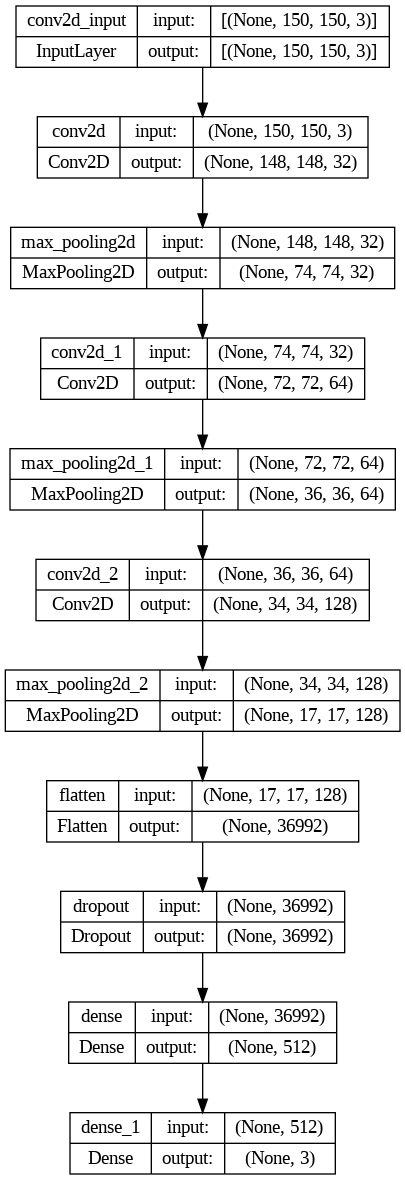

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## 6.2 - Model Training

In [ ]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/20
35/35 [==============================] - 19s 362ms/step - loss: 1.1315 - accuracy: 0.4637 - val_loss: 1.0120 - val_accuracy: 0.4463
Epoch 2/20
35/35 [==============================] - 12s 340ms/step - loss: 0.7745 - accuracy: 0.6382 - val_loss: 0.8061 - val_accuracy: 0.5620
Epoch 3/20
35/35 [==============================] - 12s 339ms/step - loss: 0.6707 - accuracy: 0.6887 - val_loss: 0.7901 - val_accuracy: 0.6612
Epoch 4/20
35/35 [==============================] - 12s 339ms/step - loss: 0.6302 - accuracy: 0.7190 - val_loss: 0.7367 - val_accuracy: 0.6639
Epoch 5/20
35/35 [==============================] - 12s 339ms/step - loss: 0.5197 - accuracy: 0.7732 - val_loss: 0.7472 - val_accuracy: 0.5978
Epoch 6/20
35/35 [==============================] - 12s 343ms/step - loss: 0.4742 - accuracy: 0.8246 - val_loss: 0.7621 - val_accuracy: 0.6584
Epoch 7/20
35/35 [==============================] - 12s 343ms/step - loss: 0.3468 - accuracy: 0.8512 - val_loss: 0.5894 - val_accuracy: 0.7287

Pada data trainig model sequential (model baseline) saya menggunakan **epochs sebanyak 20**, supaya data lebih banyak belajar dari keseluruhan training dataset.

## 6.3 - Model Evaluation

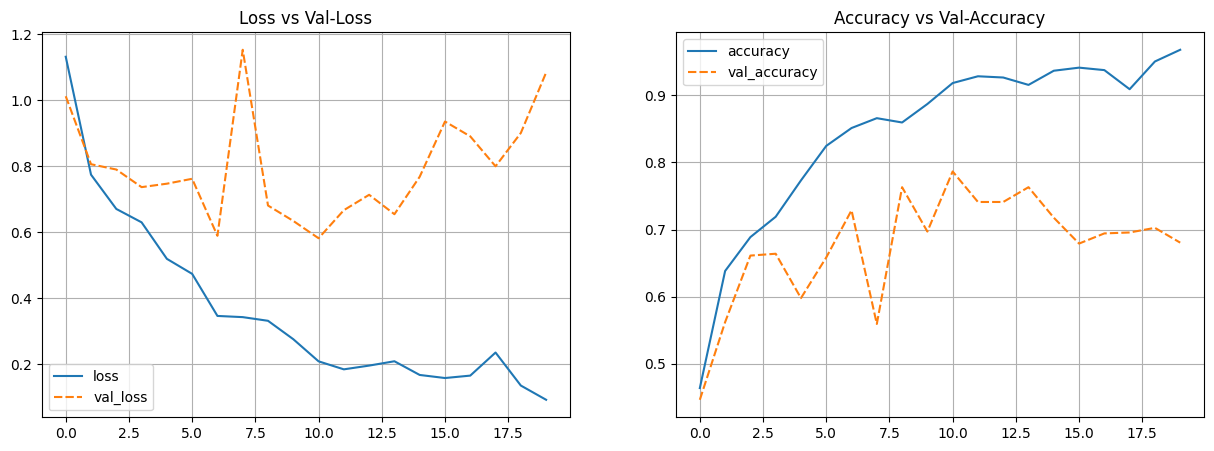

In [ ]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set_aug)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

       FRESH       0.76      0.87      0.81       178
        HALF       0.81      0.65      0.72       159
     SPOILED       0.93      0.99      0.96       114

    accuracy                           0.82       451
   macro avg       0.83      0.83      0.83       451
weighted avg       0.82      0.82      0.82       451



# 7 - ANN Improvement (Sequential API)

In [ ]:
# Download pretrained model
# Melakukan improve dengan menggunakan transfer learning menggunakan Xception

pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


Dalam konteks dataset saya, yang melibatkan klasifikasi gambar daging, fitur-fitur seperti tekstur, pola, dan detail halus mungkin penting untuk membedakan antara jenis daging yang berbeda, transfer learning menggunakan `Xception` dapat lebih efektif dalam menangkap fitur-fitur ini.

## 7.1 - Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

model_improve_tl = Sequential()
model_improve_tl.add(pretrained_model)
model_improve_tl.add(Flatten())
model_improve_tl.add(Dense(512, activation='relu'))
model_improve_tl.add(Dense(256, activation='relu')) # Menggunakan 2 Hidden Layer dg nilai neuron hidden layer kedua setengah dari nilai neuron hidden layer pertama
model_improve_tl.add(Dense(3, activation='softmax'))

# Compile
model_improve_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_improve_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 47208491 (180.09 MB)
Trainable params: 26347011 (100.51 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


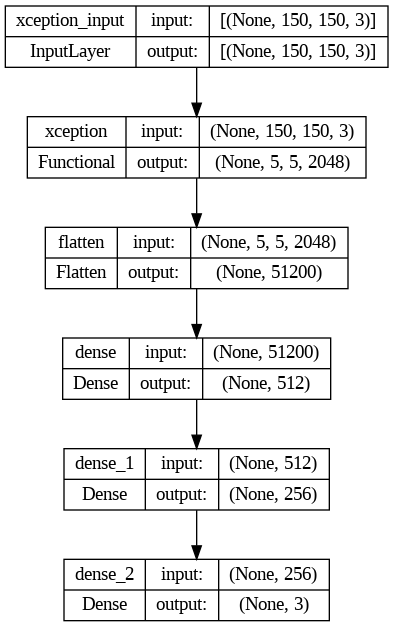

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model_improve_tl, show_shapes=True)

## 7.2 - Model Training

In [ ]:
# Train the model

%%time
history_improve_tl = model_improve_tl.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/20
35/35 [==============================] - 23s 473ms/step - loss: 3.2077 - accuracy: 0.6869 - val_loss: 1.6271 - val_accuracy: 0.6832
Epoch 2/20
35/35 [==============================] - 13s 377ms/step - loss: 0.6501 - accuracy: 0.8503 - val_loss: 1.1614 - val_accuracy: 0.7328
Epoch 3/20
35/35 [==============================] - 13s 382ms/step - loss: 0.3441 - accuracy: 0.8999 - val_loss: 1.3196 - val_accuracy: 0.7218
Epoch 4/20
35/35 [==============================] - 14s 393ms/step - loss: 0.3619 - accuracy: 0.8926 - val_loss: 1.0567 - val_accuracy: 0.7493
Epoch 5/20
35/35 [==============================] - 13s 383ms/step - loss: 0.8782 - accuracy: 0.8476 - val_loss: 1.3817 - val_accuracy: 0.7218
Epoch 6/20
35/35 [==============================] - 13s 379ms/step - loss: 0.3999 - accuracy: 0.9008 - val_loss: 1.0820 - val_accuracy: 0.7493
Epoch 7/20
35/35 [==============================] - 13s 381ms/step - loss: 0.1796 - accuracy: 0.9366 - val_loss: 0.7666 - val_accuracy: 0.7645

Pada data trainig model sequential (model improve) juga menggunakan **epochs sebanyak 20**, supaya data lebih banyak belajar dari keseluruhan training dataset.

## 7.3 - Model Evaluation

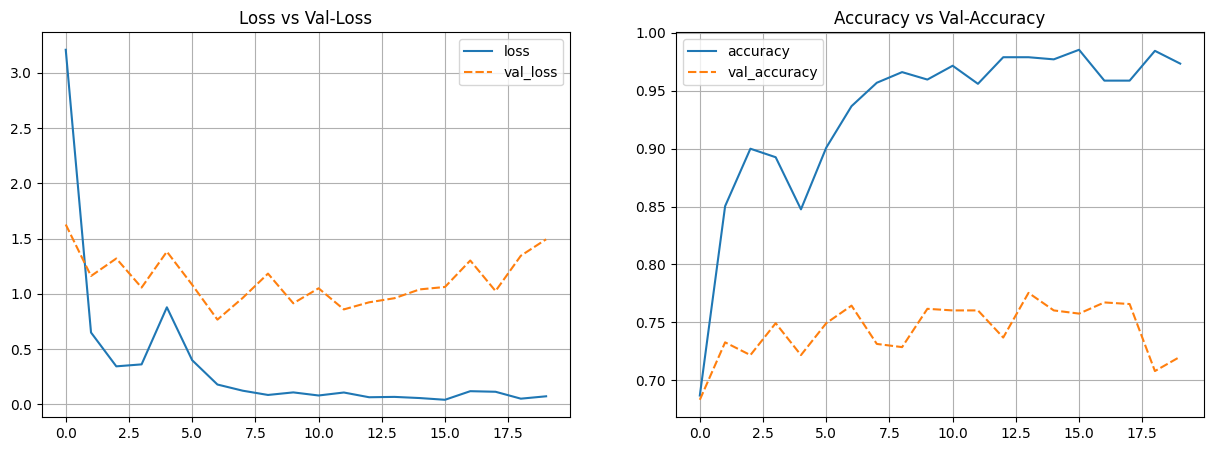

In [ ]:
# Plot training results

history_improve_tl_df = pd.DataFrame(history_improve_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_improve_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_improve_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_improve_tl.predict_generator(test_set_aug)

## Get class with maximum probability
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_tl, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

       FRESH       0.81      0.88      0.84       178
        HALF       0.79      0.79      0.79       159
     SPOILED       1.00      0.86      0.92       114

    accuracy                           0.84       451
   macro avg       0.87      0.84      0.85       451
weighted avg       0.85      0.84      0.84       451



# 8 - Model Saving

In [ ]:
model_improve_tl.trainable = False

In [ ]:
model_improve_tl.save('model_improve_tl.h5')


In [ ]:
# Download Model
from google.colab import files
files.download('model_improve_tl.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load model
model_path = 'model_improve_tl.h5'  # Ganti dengan model yang saya miliki
model = load_model(model_path)

# Load gambar dari 3 kelas
image_dir = '/content/Meat Freshness.v1-new-dataset.multiclass/train'  #  dengan path direktori yang berisi gambar
class_names = sorted(os.listdir(image_dir))

# 9 - Model Inference

In [ ]:
# Pilih beberapa gambar dari setiap kelas
num_images_per_class = 3
for class_name in class_names:
    class_path = os.path.join(image_dir, class_name)
    if os.path.isdir(class_path):  # Pastikan itu adalah direktori
        image_files = os.listdir(class_path)[:num_images_per_class]

        # Preprocessing dan prediksi untuk setiap gambar
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Load dan preprocess gambar
            img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan ukuran target dengan model Anda
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.  # Normalisasi

            # Prediksi
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Tampilkan hasil prediksi
            print(f"File: {img_file}, Actual Class: {class_name}, Predicted Class: {predicted_class}")

1/1 [==============================] - 1s 712ms/step
File: FRESH-565-_JPG.rf.0b0997836d67b393be44ca3955c8a023.jpg, Actual Class: FRESH, Predicted Class: 0
1/1 [==============================] - 0s 21ms/step
File: FRESH-36-_JPG.rf.b55f53b90915a3a0f6e290f1a29b4f8d.jpg, Actual Class: FRESH, Predicted Class: 0
1/1 [==============================] - 0s 19ms/step
File: FRESH-551-_JPG.rf.2d03041f07124e5c3c59c7c5c12d1d6c.jpg, Actual Class: FRESH, Predicted Class: 0
1/1 [==============================] - 0s 19ms/step
File: HALF-FRESH-987-_JPG.rf.e5f96c178d809f3cde674b7ae9cb7824.jpg, Actual Class: HALF, Predicted Class: 1
1/1 [==============================] - 0s 20ms/step
File: HALF-FRESH-56-_JPG.rf.d577b4b9922a7c2429786693620e07c0.jpg, Actual Class: HALF, Predicted Class: 1
1/1 [==============================] - 0s 27ms/step
File: HALF-FRESH-997-_JPG.rf.dc59087795c612c23cc0e97a23396d3f.jpg, Actual Class: HALF, Predicted Class: 1
1/1 [==============================] - 0s 24ms/step
File: SPOILED

1/1 [==============================] - 0s 20ms/step


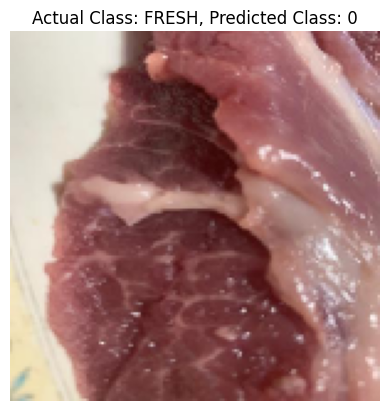

1/1 [==============================] - 0s 21ms/step


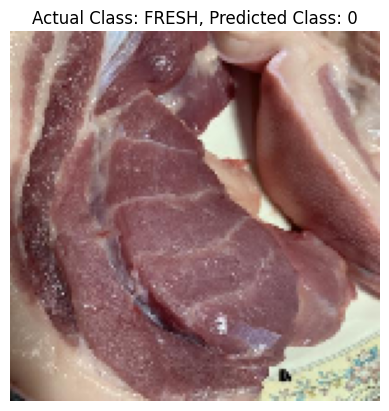

1/1 [==============================] - 0s 21ms/step


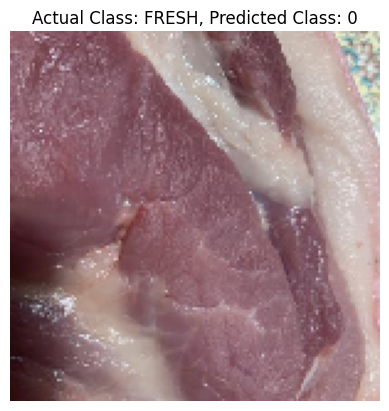

1/1 [==============================] - 0s 22ms/step


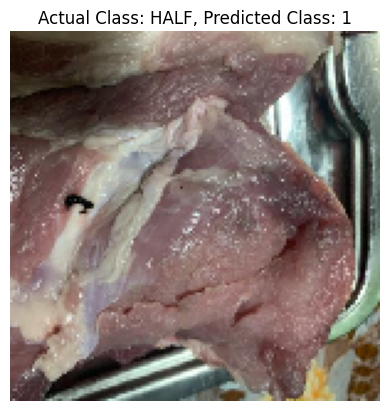

1/1 [==============================] - 0s 30ms/step


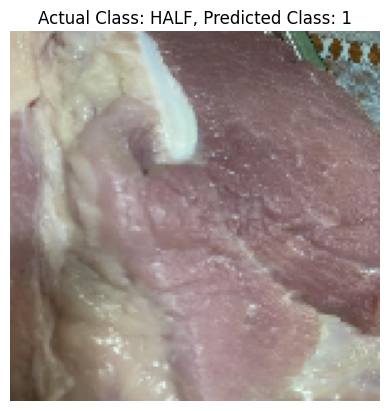

1/1 [==============================] - 0s 33ms/step


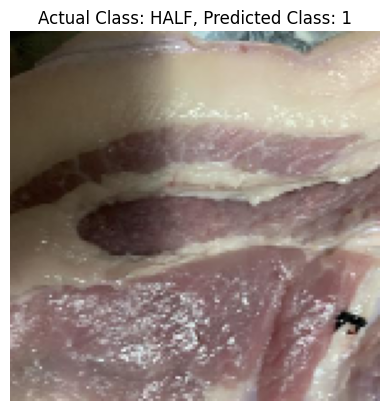

1/1 [==============================] - 0s 21ms/step


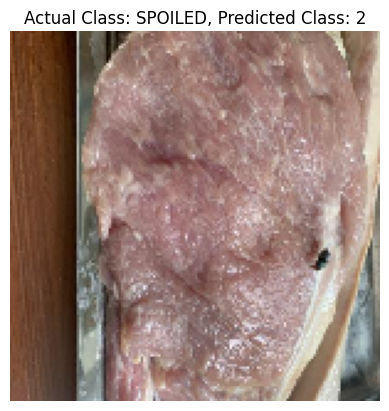

1/1 [==============================] - 0s 25ms/step


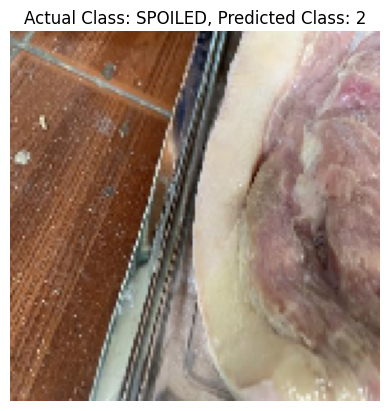

1/1 [==============================] - 0s 24ms/step


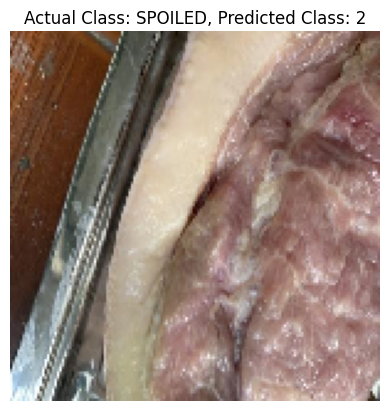

In [ ]:
# Pilih beberapa gambar dari setiap kelas
num_images_per_class = 3
for class_name in class_names:
    class_path = os.path.join(image_dir, class_name)
    if os.path.isdir(class_path):  # Pastikan itu adalah direktori
        image_files = os.listdir(class_path)[:num_images_per_class]

        # Preprocessing dan prediksi untuk setiap gambar
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Load dan preprocess gambar
            img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan ukuran target dengan model Anda
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.  # Normalisasi

            # Prediksi
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Tampilkan hasil prediksi dan visualisasi gambar
            plt.figure()
            plt.imshow(img)
            plt.title(f"Actual Class: {class_name}, Predicted Class: {predicted_class}")
            plt.axis('off')
            plt.show()

# 10 - Conclusion

- Dari keseluruhan proses, telah diakukan 2 kali modelling. Model awal yaitu model sequential baseline sebelum dilakukan improvement dengan menggunakan `1 hidden layer dan image augmentation`. Selanjutnya dilakukan `improvisasi` pada model dengan `menambahkan hidden layyer sebanyak 2 & menambahkan transfer learning dengan Xception`. Alasan menambahkan transfer learning menggunakan Xception karena klasifikasi gambar daging mungkin melibatkan fitur-fitur yang kompleks dan beragam, seperti tekstur, warna, dan pola. `Xception` memiliki kemampuan untuk menangkap fitur-fitur yang lebih abstrak dan kompleks dari gambar, sehingga lebih mampu untuk membedakan antara berbagai jenis daging berdasarkan fitur-fitur ini. Ini dapat meningkatkan kinerja model dalam membedakan antara gambar-gambar daging yang berbeda dalam dataset saya.

- Dari analisa model evaluation pada model sequential (baseline) pada visualisasi Loss Vs Val-Loss terlihat bahwa diagram tidak beraturan dan pada visuaslisasi diagram Accuracy vs Val-Accuracy overfit dimana nilai dari Classification Report diperoleh `nilai accuracy sebesar 0.82`. Setelah dilakukan improvement pada model sequential, model menjadi lebih baik, pada visualisasi Loss Vs Val-Loss terlihat bahwa diagram lebih beraturan & hampir bertemu dan pada visuaslisasi diagram Accuracy vs Val-Accuracy overfit berkurang dimana nilai dari Classification Report diperoleh `nilai accuracy meningkat yaitu sebesar 0,88`.

- Hal itu dibuktikan dengan melakukan prediksi pada model inference notebook yg sama ini dari 9 gambar random dengan 3 gambar dari tiap kelas, dengan 3 gambar dari daging kelas `fresh`, 3 gambar dari daging kelas `Half` & 3 gambar dari daging kelas `Spoiled`. Dari 9 gambar tersebut model dapat melakukan `prediksi 100% benar memprediksi gambar dan kelasnya`. Pada pembuatan model inference yg lain dicoba memberikan 3 gambar daging dimana model mampu mendeteksi dengan benar ketiga kelasnya.

- Pembuatan model ini dapat digunakan namun perlu ditinjau ulang untuk mampu mendapatakan nilai accuracy yg lebih besar lagi dan membuat model menjadi lebih goodfit. Selain itu jika masih ada waktu lebih bisa dilakukan penambahan nilai epoch yang lebih besar sampai terjadi callback pada proses training data.